# Exploration of different AGE BAND approaches and how they affect speed

**Description**: 

This notebook looks at how fast different ways of computing agebands
are, using 1, 10 and 30 age columns, and 10 million rows of fake data.

- pandas UDF - pandas.cut
- UDF - if then else
- JOIN BETWEEN
- JOIN equals
- CASE WHEN

**Author**: Sam Hollings

In [0]:
try:
  import google.colab
  IN_COLAB = True
  %pip install pyspark
except:
  IN_COLAB = False

In [0]:
if IN_COLAB: # Import SparkSession
  from pyspark.sql import SparkSession
  # Create a Spark Session
  spark = SparkSession.builder.master("local[*]").getOrCreate()

### get data

In [0]:
import numpy as np
import pandas as pd

def make_random_dataset(database='default', number_of_feature_cols = 30, number_of_rows = 10000000, 
                        batch_size = 1000000, column_name_root = 'AGE', table_name = 'random_dataset', table_ACL=False):
    """Make a dataset (in a table) with random values between 0 and 120 with the specified number_of_rows and feature columns and a patient_id field. 
  
    Returns a pyspark dataframe of the dataset (and there will also be a hard table of the dataset made)

    Parameters
    ----------
    database : str
        
    number_of_feature_cols : int
        
    number_of_rows : int
        
    batch_size : int
        
    column_name_root : str
        
    table_name : str
        
    table_ACL : bool
        
    Returns
    -------
    sdf_random_dataset : pyspark.DataFrame

    Examples
    --------
    >>> sdf_random_dataset = make_random_dataset()
    >>> sdf_random_dataset.count()
    10000000
    """

    column_list = [f'{column_name_root}{x}' for x in range(0,number_of_feature_cols)]

    df_random_dataset = pd.DataFrame(np.random.randint(0,120,size=(batch_size, number_of_feature_cols)), columns=column_list).rename_axis(index='patient_id').reset_index()
    sdf_random_dataset = spark.createDataFrame(df_random_dataset)
    sdf_random_dataset.createOrReplaceGlobalTempView(table_name)

    # drop table if it already existed
    spark.sql(f"""DROP TABLE IF EXISTS {database}.{table_name}""")

    # make the table and first batch
    number_of_batches = int(number_of_rows / batch_size)

    spark.sql(f"""CREATE TABLE IF NOT EXISTS {database}.{table_name} AS
     SELECT * FROM global_temp.{table_name};
     """)

    if table_ACL: # if databricks has table ACL then you need to ALTER the table OWNERship
        spark.sql(f"""ALTER TABLE {database}.{table_name} OWNER TO {database}""")

    for batch in range(0, number_of_batches-1):

        spark.sql(f"""INSERT INTO {database}.{table_name}
          SELECT * FROM global_temp.{table_name}""")

    return spark.table(f"{database}.{table_name}")

In [0]:
# %sql
# refresh table default.random_dataset

In [0]:
database = 'default'

spark.sql(f"DROP TABLE IF EXISTS {database}.random_dataset")
make_random_dataset(database=database, number_of_feature_cols = 30, number_of_rows = 10000000, 
                        batch_size = 1000000, column_name_root = 'AGE', table_name = 'random_dataset', table_ACL=False)

df_data = spark.table(f"{database}.random_dataset")#.limit(1000)
age_cols = df_data.drop('patient_id').columns

### Define the methods

In [0]:
%python 
import pandas as pd
from pyspark.sql.functions import pandas_udf, PandasUDFType, lit, col, when,array, split, explode, isnull, udf

In [0]:
# from pyspark.ml.feature import Bucketizer



In [0]:
sql_ageband_casewhen_string = '''CASE WHEN {0} >= 0 and {0} <=18 THEN '0-18'
  WHEN {0} >= 19 and {0} <=30 THEN '19-30'
  WHEN {0} >= 31 and {0} <=39 THEN '31-39'
  WHEN {0} >= 40 and {0} <=49 THEN '40-49'
  WHEN {0} >= 50 and {0} <=59 THEN '50-59'
  WHEN {0} >= 60 and {0} <=69 THEN '60-69'
  WHEN {0} >= 70 and {0} <=79 THEN '70-79'
  WHEN {0} >= 80 and {0} <=89 THEN '80-89'
  WHEN {0} >= 90 and {0} <=150 THEN '90+' END as {0}_band'''

def selectExpr_sql_ageband_casewhen(df_data=df_data, age_cols=age_cols):
  return df_data.selectExpr('*', *[sql_ageband_casewhen_string.format(col) for col in age_cols])

#display(selectExpr_sql_ageband_casewhen())

In [0]:
def spark_sql_ageband_casewhen(df_data=df_data, age_cols=age_cols):
  return spark.sql("SELECT "+",".join(['*']+[sql_ageband_casewhen_string.format(col) for col in age_cols])+f" FROM {database}.random_dataset")

#display(spark_sql_ageband_casewhen())

In [0]:
def ageband_func(age):
  if age is None:
    return None
  
  if   age >= 0 and age <=18:    return '0-18'
  elif age >= 19 and age <=30:    return '19-30'
  elif age >= 31 and age <=39:    return '31-39'
  elif age >= 40 and age <=49:    return '40-49'
  elif age >= 50 and age <=59:    return '50-59'
  elif age >= 60 and age <=69:    return '60-69'
  elif age >= 70 and age <=79:    return '70-79'
  elif age >= 80 and age <=89:    return '80-89'
  elif age >= 90 and age <=150:    return '90+'
  
ageband_udf = udf(ageband_func)

def udf_ageband(df_data=df_data, age_cols=age_cols):
  return df_data.select("*", *[ageband_udf(col).alias(f"{col}_band") for col in age_cols])

# display(df_data.select("*", *[ageband_udf(col).alias(f"{col}_band") for col in age_cols]))

In [0]:
@pandas_udf('string', PandasUDFType.SCALAR)
def ageband_cut(age_series : pd.Series(str)) -> pd.Series:

  return pd.cut(age_series,[0, 19, 31, 40, 50, 60, 70, 80, 90, 1000], labels=['0-18','19-30', '31-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+'], retbins=False, right=False)

def pandas_udf_cut_ageband(df_data=df_data, age_cols=age_cols):
  return df_data.select("*", *[ageband_cut(col).alias(f"{col}_band") for col in age_cols])

# display(df_data.select("*", *[ageband_cut(col).alias(f"{col}_band") for col in age_cols]))

/databricks/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
 warnings.warn(

In [0]:
%python
import pandas as pd
agegroup_lookup = pd.DataFrame([dict(lower_age = 0, upper_age=18, age_group='0-18'),
                   dict(lower_age = 19, upper_age=30, age_group='19-30'),
                   dict(lower_age = 31, upper_age=39, age_group='31-39'),
                   dict(lower_age = 40, upper_age=49, age_group='40-49'),
                   dict(lower_age = 50, upper_age=59, age_group='50-59'),
                   dict(lower_age = 60, upper_age=69, age_group='60-69'),
                   dict(lower_age = 70, upper_age=79, age_group='70-79'),
                   dict(lower_age = 80, upper_age=89, age_group='80-89'),
                   dict(lower_age = 90, upper_age=150, age_group='90+')])
                   
sdf_agegroup_lookup = spark.createDataFrame(agegroup_lookup)
sdf_agegroup_lookup.createOrReplaceGlobalTempView('agegroup_lookup')

In [0]:
%python
agegroup_lookup['age'] = agegroup_lookup.apply(lambda x: list(range(x['lower_age'],x['upper_age']+1)),axis=1)
agegroup_lookup_explode = agegroup_lookup.set_index('age_group').explode('age')['age']
sdf_agegroup_lookup_long = spark.createDataFrame(agegroup_lookup_explode.reset_index())
sdf_agegroup_lookup_long.createOrReplaceGlobalTempView('agegroup_lookup_long')

In [0]:
def chain_join_long_ageband(df_data=df_data, age_cols=age_cols):
  df_data_ageband_join = df_data
  for col in age_cols:
    df_data_ageband_join = df_data_ageband_join.join(sdf_agegroup_lookup_long, df_data[col]==sdf_agegroup_lookup_long['age'], how='left').withColumnRenamed('age_group',f"{col}_band").drop('age')
  return df_data_ageband_join
# display(chain_join_long_ageband())

In [0]:
def chain_join_between_ageband(df_data=df_data, age_cols=age_cols):
  df_data_ageband_join = df_data
  for col in age_cols:
    df_data_ageband_join = df_data_ageband_join.join(sdf_agegroup_lookup, (df_data[col] >= sdf_agegroup_lookup['lower_age']) & (df_data[col] <= sdf_agegroup_lookup['upper_age']), how='left').withColumnRenamed('age_group',f"{col}_band").drop('lower_age', 'upper_age')
  return df_data_ageband_join
# display(chain_join_between_ageband())

### Compare how quickly each method can determine agebands

In [0]:
def time_function(func, *args):
    import time 
    t1 = time.time()
    result = func(*args)
    t2 = time.time()
    total_time = t2-t1
    return total_time, result

In [0]:
def avg_time_function(iters, func, *args):
    total_time = 0
    for _ in range(iters):
        time, _ = time_function(func, *args)
        total_time += time
    return (total_time/iters)

In [0]:
def process_df(df):
    df_count = df.count()
    return df, df_count

In [0]:
def print_avg(num_iterations, data_df=df_data, age_cols=age_cols):
    num_rows = data_df.count()
    #####################################################
    # Need to change these to be a set of dataframes that I want to test, i.e. sql_df, udf_df, pandas_udf_df, etc...
    methods_dict = dict(
                        selectExpr_sql_ageband_casewhen_sdf = selectExpr_sql_ageband_casewhen(df_data=data_df, age_cols=age_cols) ,
                        spark_sql_ageband_casewhen_sdf = spark_sql_ageband_casewhen(df_data=data_df, age_cols=age_cols) ,
                        udf_ageband_sdf = udf_ageband(df_data=data_df, age_cols=age_cols) ,
                        pandas_udf_cut_ageband_sdf = pandas_udf_cut_ageband(df_data=data_df, age_cols=age_cols) ,
                        chain_join_long_ageband_sdf = chain_join_long_ageband(df_data=data_df, age_cols=age_cols) ,
                        chain_join_between_ageband_sdf = chain_join_between_ageband(df_data=data_df, age_cols=age_cols),
                        #mlib_bucketizer = ...,
                        )
    #####################################################
    
    results = []
    for name, df in methods_dict.items():
        average_run_time = avg_time_function(num_iterations, process_df, df)
        print("average run_time for {name} with {num_rows} rows is {average_run_time}".format(name=name, average_run_time=average_run_time, num_rows=num_rows))
        
        results.append(dict(name=name, num_cols=len(age_cols), num_rows=num_rows, average_run_time=average_run_time))
    
    return pd.DataFrame(results)

In [0]:
import numpy as np

df_results = pd.concat([print_avg(5, age_cols=age_cols[:num_cols]) for num_cols in [1,10,30]],axis=0)

average run_time for selectExpr_sql_ageband_casewhen_sdf with 10000000 rows is 0.4371189117431641
average run_time for spark_sql_ageband_casewhen_sdf with 10000000 rows is 0.3901240825653076
average run_time for udf_ageband_sdf with 10000000 rows is 0.4120791912078857
average run_time for pandas_udf_cut_ageband_sdf with 10000000 rows is 0.3226802825927734
average run_time for chain_join_long_ageband_sdf with 10000000 rows is 2.653098201751709
average run_time for chain_join_between_ageband_sdf with 10000000 rows is 0.7332707405090332
average run_time for selectExpr_sql_ageband_casewhen_sdf with 10000000 rows is 0.2854585647583008
average run_time for spark_sql_ageband_casewhen_sdf with 10000000 rows is 0.28106012344360354
average run_time for udf_ageband_sdf with 10000000 rows is 0.28046612739562987
average run_time for pandas_udf_cut_ageband_sdf with 10000000 rows is 0.2902533531188965
average run_time for chain_join_long_ageband_sdf with 10000000 rows is 3.0776185989379883
average run_time for chain_join_between_ageband_sdf with 10000000 rows is 3.924434185028076
average run_time for selectExpr_sql_ageband_casewhen_sdf with 10000000 rows is 0.28058795928955077
average run_time for spark_sql_ageband_casewhen_sdf with 10000000 rows is 0.27974514961242675
average run_time for udf_ageband_sdf with 10000000 rows is 0.22845120429992677
average run_time for pandas_udf_cut_ageband_sdf with 10000000 rows is 0.2345099925994873
average run_time for chain_join_long_ageband_sdf with 10000000 rows is 7.308137464523315
average run_time for chain_join_between_ageband_sdf with 10000000 rows is 124.1311773300171

### Results

In [0]:
df_results

Out[19]:

,name,num_cols,num_rows,average_run_time
0,selectExpr_sql_ageband_casewhen_sdf,1,10000000,0.437119
1,spark_sql_ageband_casewhen_sdf,1,10000000,0.390124
2,udf_ageband_sdf,1,10000000,0.412079
3,pandas_udf_cut_ageband_sdf,1,10000000,0.322680
4,chain_join_long_ageband_sdf,1,10000000,2.653098
5,chain_join_between_ageband_sdf,1,10000000,0.733271
0,selectExpr_sql_ageband_casewhen_sdf,10,10000000,0.285459
1,spark_sql_ageband_casewhen_sdf,10,10000000,0.281060
2,udf_ageband_sdf,10,10000000,0.280466
3,pandas_udf_cut_ageband_sdf,10,10000000,0.290253


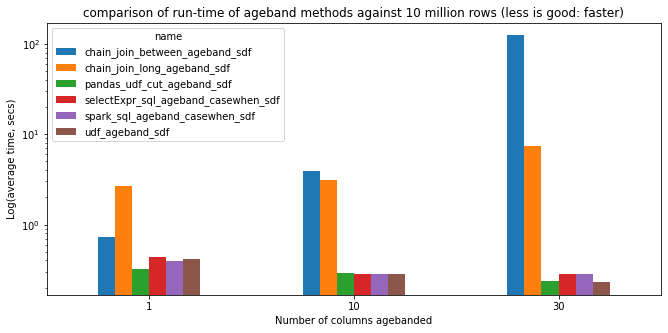

In [0]:
df_results.set_index(['num_cols','name']).unstack()['average_run_time'].plot.bar(figsize=(11,5), 
                                                                                 logy=True, 
                                                                                 rot=0, 
                                                                                 title='comparison of run-time of ageband methods against 10 million rows (less is good: faster)', 
                                                                                 ylabel='Log(average time, secs)',
                                                                                 xlabel='Number of columns agebanded'
                                                                                );